## Importing Libraries and dataset

In [118]:
# Importing libraries 
import pandas as pd
import talib
import yfinance as yf
import spacy
import matplotlib.pyplot as plt
import plotly.express as px
import nltk
import re


from spacy.lang.en import English
from spacy.matcher import PhraseMatcher
from scipy.stats import pearsonr, spearmanr
# from nltk.tokenize import word_tokenize
# from nltk.tag import pos_tag
# from nltk.corpus import stopwords
# from nltk.probability import FreqDist
from nltk.sentiment import SentimentIntensityAnalyzer
# import nltk
from textblob import TextBlob

In [119]:
# import importlib
# importlib.reload(nltk)

In [ ]:

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
nlp = spacy.load('en_core_web_sm')

In [121]:
# Importing dataset from file 
dataset = pd.read_csv('../data/raw_analyst_ratings.csv')

## Task-1

### 1. Descriptive Statistics

In [122]:
headline_lengths = [len(headline) for headline in dataset['headline']]
total_headlines = len(dataset['headline'])
print(f"The total headlines are {total_headlines}.")

The total headlines are 1407328.


In [123]:
min_length = min(headline_lengths)
max_length = max(headline_lengths)
average_length = sum(headline_lengths) / total_headlines
print(f"The minimum, maximum and avarage length of a headlines are {min_length}, {max_length} and {round(average_length, 2)} respectively.")

The minimum, maximum and avarage length of a headlines are 3, 512 and 73.12 respectively.


In [124]:
article_count = dataset['publisher'].value_counts()
print(f"The number of articles published are {article_count}.")

The number of articles published are publisher
Paul Quintaro                      228373
Lisa Levin                         186979
Benzinga Newsdesk                  150484
Charles Gross                       96732
Monica Gerson                       82380
                                    ...  
Shazir Mucklai - Imperium Group         1
Laura Jennings                          1
Eric Martin                             1
Jose Rodrigo                            1
Jeremie Capron                          1
Name: count, Length: 1034, dtype: int64.


In [125]:
dataset.head()

,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A


In [126]:
dataset["date"] = pd.DataFrame(dataset["date"])
dataset['date'] = pd.to_datetime(dataset['date'], errors='coerce')


In [127]:
dataset['day_of_week'] = dataset['date'].dt.day_name()
dataset['month'] = dataset['date'].dt.month
dataset['year'] = dataset['date'].dt.year

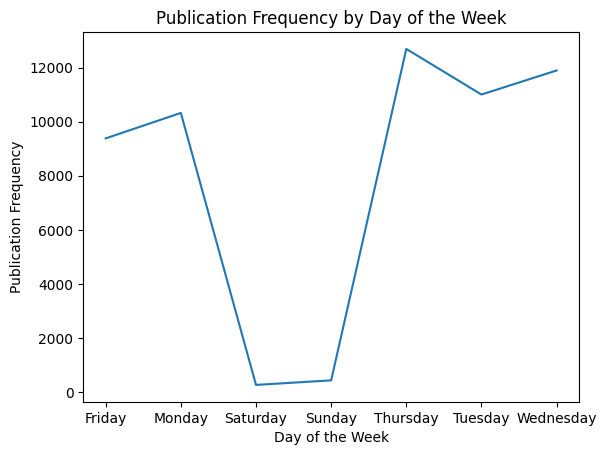

In [128]:
day_of_week_counts = dataset['day_of_week'].value_counts().sort_index()
plt.plot(day_of_week_counts.index, day_of_week_counts.values)
plt.xlabel('Day of the Week')
plt.ylabel('Publication Frequency')
plt.title('Publication Frequency by Day of the Week')
plt.show()

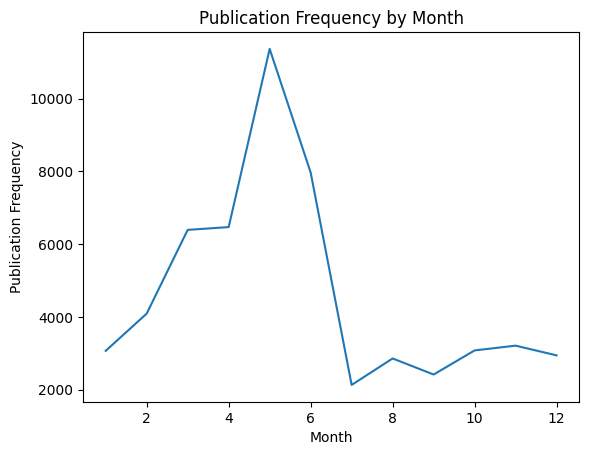

In [129]:
month_counts = dataset['month'].value_counts().sort_index()
plt.plot(month_counts.index, month_counts.values)
plt.xlabel('Month')
plt.ylabel('Publication Frequency')
plt.title('Publication Frequency by Month')
plt.show()

### 2. Text Analysis (Sentiment analysis & Topic Modeling)

In [130]:
for headline in dataset['headline'].head(10):
    sentiment = SentimentIntensityAnalyzer().polarity_scores(headline)
    compound_score = sentiment['compound']
    
    if compound_score > 0:
        print(f"Positive: {headline}")
    elif compound_score < 0:
        print(f"Negative: {headline}")
    else:
        print(f"Neutral: {headline}")

Neutral: Stocks That Hit 52-Week Highs On Friday
Neutral: Stocks That Hit 52-Week Highs On Wednesday
Neutral: 71 Biggest Movers From Friday
Neutral: 46 Stocks Moving In Friday's Mid-Day Session
Positive: B of A Securities Maintains Neutral on Agilent Technologies, Raises Price Target to $88
Negative: CFRA Maintains Hold on Agilent Technologies, Lowers Price Target to $85
Neutral: UBS Maintains Neutral on Agilent Technologies, Raises Price Target to $87
Positive: Agilent Technologies shares are trading higher after the company reported better-than-expected Q2 EPS and sales results.
Negative: Wells Fargo Maintains Overweight on Agilent Technologies, Raises Price Target to $95
Neutral: 10 Biggest Price Target Changes For Friday


In [131]:
nlp = spacy.load('en_core_web_sm')
tokenizer = English().tokenizer

In [132]:
def extract_keywords(text):
    doc = nlp(text)
    
    keywords = []
    
    for chunk in doc.noun_chunks:
        keywords.append(chunk.text)
    
    topic_phrases = ["FDA approval", "price target"]
    
    matcher = PhraseMatcher(nlp.vocab)
    patterns = [nlp(phrase) for phrase in topic_phrases]
    matcher.add("TopicPhrases", None, *patterns)
    
    matches = matcher(doc)
    for match_id, start, end in matches:
        matched_span = doc[start:end]
        keywords.append(matched_span.text)
    
    return keywords

In [133]:
dataset['keywords'] = dataset["headline"].head().apply(extract_keywords)
print(dataset['keywords'])

0                      [Stocks, That, 52-Week Highs, Friday]
1                   [Stocks, That, 52-Week Highs, Wednesday]
2                                [71 Biggest Movers, Friday]
3                      [46 Stocks, Friday's Mid-Day Session]
4          [B, A Securities Maintains Neutral, Agilent Te...
                                 ...                        
1407323                                                  NaN
1407324                                                  NaN
1407325                                                  NaN
1407326                                                  NaN
1407327                                                  NaN
Name: keywords, Length: 1407328, dtype: object


### 3. Time Series Analysis

In [134]:
publication_counts = dataset.groupby(dataset['date'].dt.date).size()

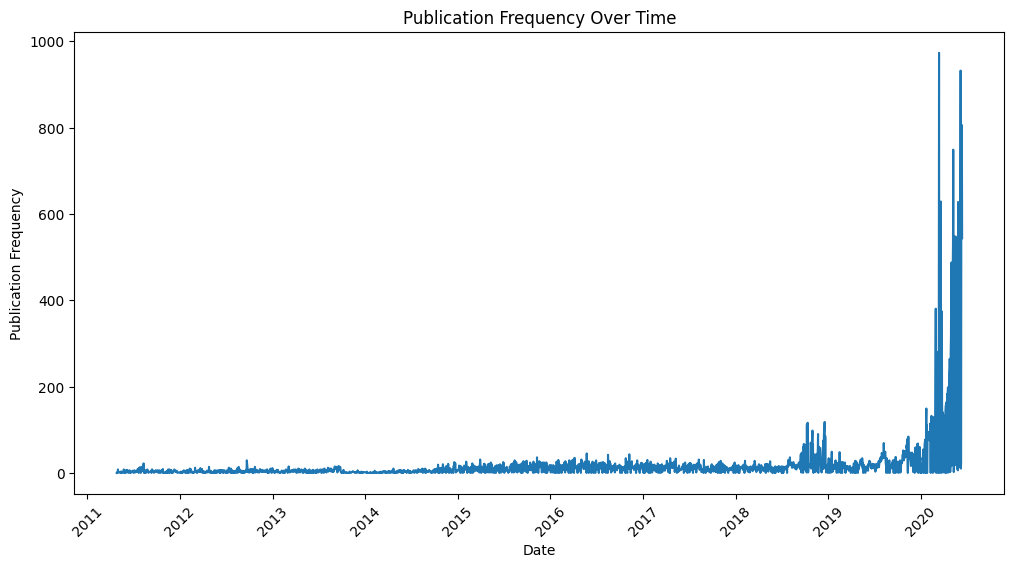

In [135]:
plt.figure(figsize=(12, 6))
plt.plot(publication_counts.index, publication_counts.values)
plt.xlabel('Date')
plt.ylabel('Publication Frequency')
plt.title('Publication Frequency Over Time')
plt.xticks(rotation=45)
plt.show()

In [136]:
hourly_counts = dataset.set_index('date').resample('H').size()
print(hourly_counts)

C:\Users\Eyobe\AppData\Local\Temp\ipykernel_10868\1377994361.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_counts = dataset.set_index('date').resample('H').size()


date
2011-04-27 21:00:00-04:00    1
2011-04-27 22:00:00-04:00    0
2011-04-27 23:00:00-04:00    0
2011-04-28 00:00:00-04:00    0
2011-04-28 01:00:00-04:00    0
                            ..
2020-06-11 13:00:00-04:00    1
2020-06-11 14:00:00-04:00    8
2020-06-11 15:00:00-04:00    2
2020-06-11 16:00:00-04:00    6
2020-06-11 17:00:00-04:00    3
Length: 79989, dtype: int64


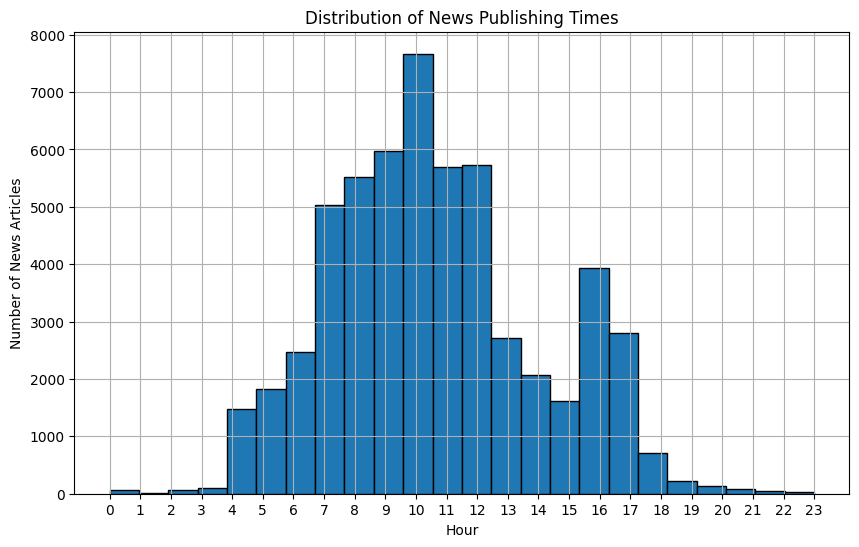

In [137]:
plt.figure(figsize=(10, 6))
dataset['date'].dt.hour.hist(bins=24, edgecolor='black')
plt.xlabel('Hour')
plt.ylabel('Number of News Articles')
plt.title('Distribution of News Publishing Times')
plt.xticks(range(0, 24))
plt.show()

### 4. Publisher Analysis

In [138]:
publisher_counts = dataset['publisher'].value_counts().head(5).sort_values(ascending=False)

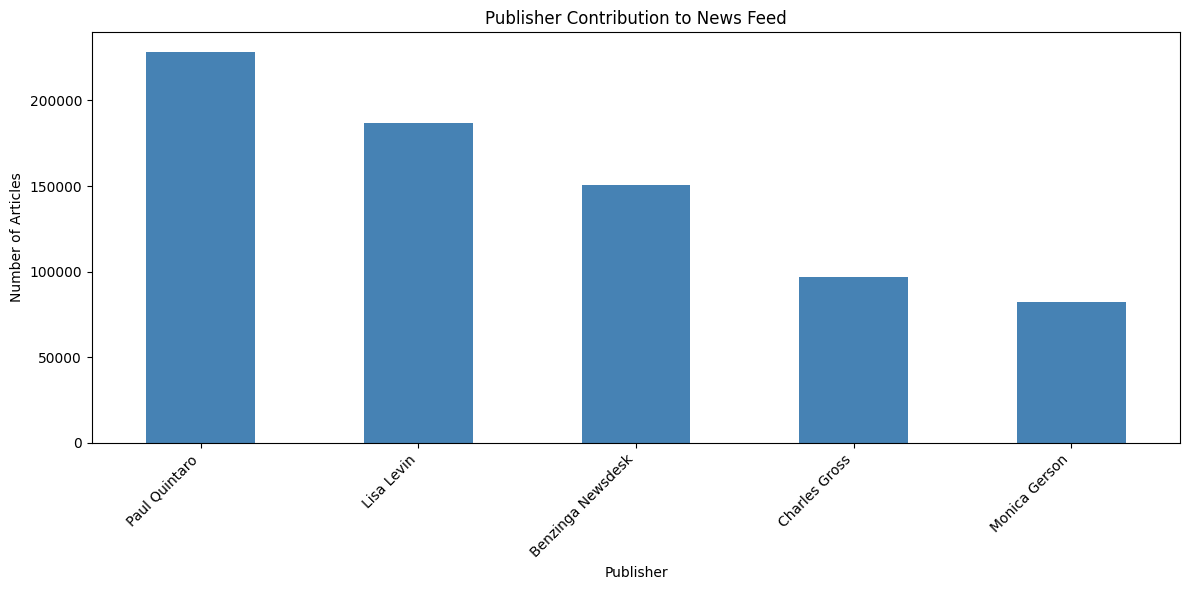

In [139]:
plt.figure(figsize=(12, 6))
ax = publisher_counts.plot(kind='bar', color='steelblue')
ax.set_xlabel('Publisher')
ax.set_ylabel('Number of Articles')
ax.set_title('Publisher Contribution to News Feed')
ax.set_xticklabels(publisher_counts.index, rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [140]:
top_publishers = publisher_counts.head(5).index
subset_data = dataset[dataset['publisher'].isin(top_publishers)]

In [141]:
for publisher in top_publishers:
    publisher_data = subset_data[subset_data['publisher'] == publisher]
    print(publisher_data)

         Unnamed: 0                                           headline  \
209             209  Agilent Reports Purchase Of Genohm, No Terms D...   
212             212  UPDATE: Alnylam, Agilent Deal Has Initial Term...   
213             213  Alnylam Pharma 8-K Shows Co. Entered Manufactu...   
225             225  Agilent Reports Purchase Of Luxcel Biosciences...   
233             233  Agilent Sees Q1 Adj. EPS $0.55-$0.57 vs $0.60 ...   
...             ...                                                ...   
1407290     1413811  China Zenix Auto Int'l Reports Q2 Loss $0.01, ...   
1407293     1413814  China Zenix Auto Q1 EPS $0.00, Revenue $116.5M...   
1407304     1413825  China Zenix Auto International Limited Reports...   
1407311     1413832  China Zenix Auto Shares Halted on NYSE Just Fo...   
1407313     1413834  China Zenix Auto International Limited Reports...   

                                                       url      publisher  \
209      https://www.benzinga.com/

In [142]:
def extract_domain(email):
    match = re.search("@[\w.]+", email)
    if match:
        return match.group()[1:]
    else:
        return None

<>:2: SyntaxWarning: invalid escape sequence '\w'
<>:2: SyntaxWarning: invalid escape sequence '\w'
C:\Users\Eyobe\AppData\Local\Temp\ipykernel_10868\1887508577.py:2: SyntaxWarning: invalid escape sequence '\w'
  match = re.search("@[\w.]+", email)


In [143]:
dataset['domain'] = dataset['publisher'].apply(extract_domain)
domain_counts = dataset['domain'].value_counts()

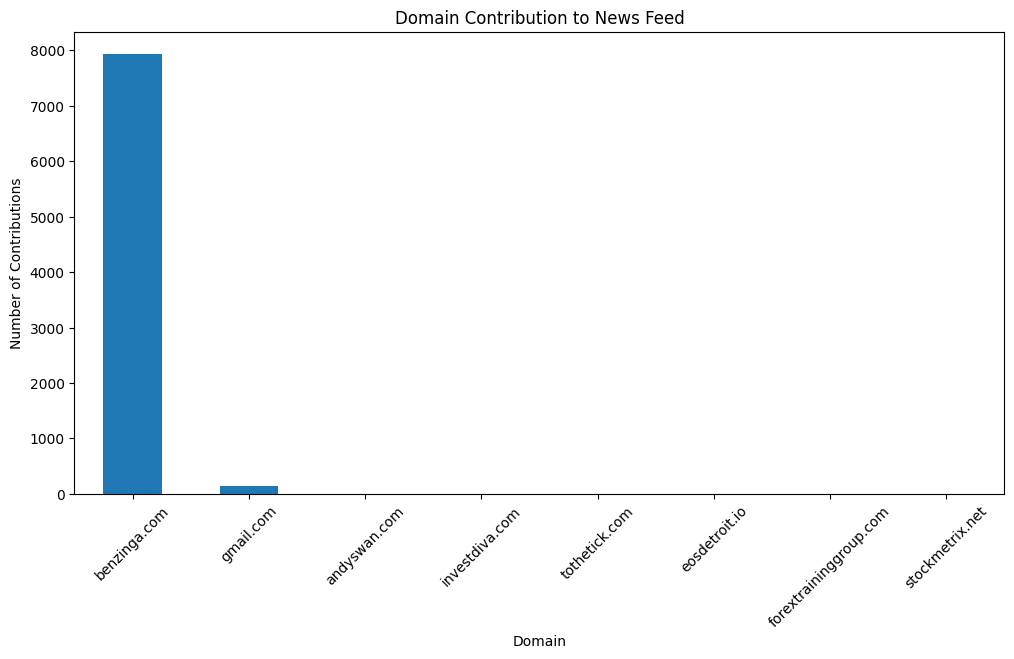

In [144]:
plt.figure(figsize=(12, 6))
domain_counts.plot(kind='bar')
plt.xlabel('Domain')
plt.ylabel('Number of Contributions')
plt.title('Domain Contribution to News Feed')
plt.xticks(rotation=45)
plt.show()

## Task-2

### 5. Stock price fetching 

In [145]:
dataset = dataset[['date', 'stock']]
dataset.head()

,date,stock
0,2020-06-05 10:30:54-04:00,A
1,2020-06-03 10:45:20-04:00,A
2,2020-05-26 04:30:07-04:00,A
3,2020-05-22 12:45:06-04:00,A
4,2020-05-22 11:38:59-04:00,A


In [146]:
unique_values = dataset['stock'].unique()
unique_values

array(['A', 'AA', 'AAC', ..., 'ZU', 'ZUMZ', 'ZX'], dtype=object)

In [147]:
grouped_data = dataset.groupby('stock')

In [148]:
earliest_dates = grouped_data['date'].min()
latest_dates = grouped_data['date'].max()

print(earliest_dates, latest_dates)

stock
A      2020-05-22 08:06:17-04:00
AA     2020-05-18 10:50:11-04:00
AAC    2019-08-30 08:10:37-04:00
AADR   2013-03-05 15:42:46-04:00
AAL    2020-06-08 10:19:28-04:00
                  ...           
ZTR    2016-04-01 15:23:43-04:00
ZTS    2020-05-05 12:44:19-04:00
ZU     2015-08-17 10:36:13-04:00
ZUMZ   2020-04-13 10:01:37-04:00
ZX     2017-11-14 13:25:57-04:00
Name: date, Length: 6204, dtype: datetime64[ns, UTC-04:00] stock
A      2020-06-05 10:30:54-04:00
AA     2020-06-09 10:52:15-04:00
AAC    2019-10-25 16:09:59-04:00
AADR   2013-09-06 15:06:35-04:00
AAL    2020-06-10 11:21:01-04:00
                  ...           
ZTR    2020-03-19 10:49:42-04:00
ZTS    2020-06-11 10:22:31-04:00
ZU     2020-01-09 14:34:23-04:00
ZUMZ   2020-06-05 07:24:15-04:00
ZX     2018-06-15 09:01:12-04:00
Name: date, Length: 6204, dtype: datetime64[ns, UTC-04:00]


In [149]:
stock_dataset = pd.DataFrame()

## Task-3

### 6. Quantitative analysis

In [150]:
for stock, earliest_date in earliest_dates.items():
    latest_date = latest_dates[stock]
    
    stock_data = yf.download(stock, start=earliest_date, end=latest_date)
    
    stock_data['stock'] = stock
    stock_dataset = pd.concat([stock_dataset, stock_data], ignore_index=True)

print(stock_dataset)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['AAC']: Exception('%ticker%: No timezone found, symbol may be delisted')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['AAMC']: Exception("%ticker%: Data doesn't exist for startDate = 1551288003, endDate = 1589197631")
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['AAN']: Exception("%ticker%: Data doesn't exist for startDate = 1588951703, endDate = 1591799794")
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*****************

KeyboardInterrupt: 

In [151]:
reason = talib.RSI(stock_dataset["Close"])
print(reason)

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
           ...    
90208    19.855373
90209    15.497954
90210    15.095159
90211     9.051256
90212    10.438702
Length: 90213, dtype: float64


In [152]:
macd, signal, hist = talib.MACD(stock_dataset["Close"], fastperiod=12, slowperiod=26, signalperiod=9)
macd, signal, hist

(0             NaN
 1             NaN
 2             NaN
 3             NaN
 4             NaN
            ...   
 90208   -0.258769
 90209   -0.373965
 90210   -0.465540
 90211   -0.665200
 90212   -0.809263
 Length: 90213, dtype: float64,
 0             NaN
 1             NaN
 2             NaN
 3             NaN
 4             NaN
            ...   
 90208   -0.049724
 90209   -0.114572
 90210   -0.184766
 90211   -0.280853
 90212   -0.386535
 Length: 90213, dtype: float64,
 0             NaN
 1             NaN
 2             NaN
 3             NaN
 4             NaN
            ...   
 90208   -0.209045
 90209   -0.259392
 90210   -0.280774
 90211   -0.384348
 90212   -0.422728
 Length: 90213, dtype: float64)

In [153]:
stock_dataset['returns'] = stock_dataset['Close'].pct_change()

stock_dataset['moving_average'] = stock_dataset['Close'].rolling(window=3).mean()

stock_dataset['cumulative_returns'] = (1 + stock_dataset['returns']).cumprod()

stock_dataset['vwap'] = (stock_dataset['Close'] * stock_dataset['Volume']).cumsum() / stock_dataset['Volume'].cumsum()

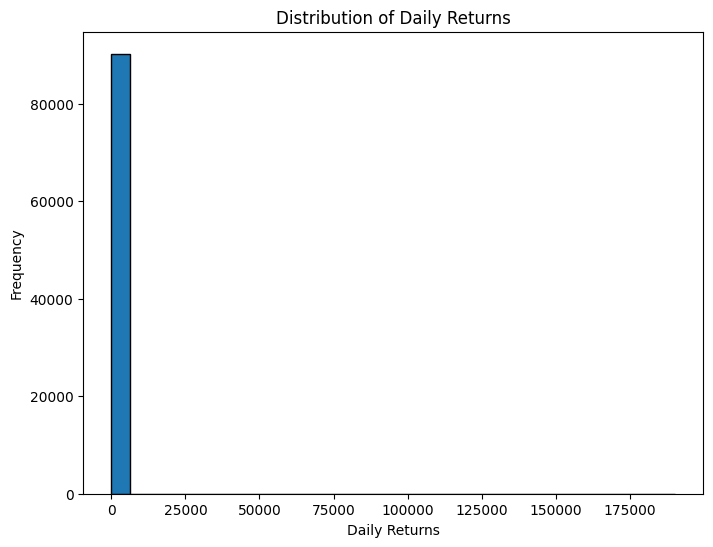

In [154]:
plt.figure(figsize=(8, 6))
plt.hist(stock_dataset['returns'].dropna(), bins=30, edgecolor='black')
plt.xlabel('Daily Returns')
plt.ylabel('Frequency')
plt.title('Distribution of Daily Returns')
plt.show()

## Task-4

### 7. Correlation between news and stock movement

In [155]:
unique_values = dataset['stock'].unique()
stock_dataset = pd.DataFrame()

In [156]:
for stock in unique_values:
    stock_data = yf.Ticker(stock)
    
    stock_dataset = pd.concat([stock_dataset, stock_data.history(period="max")])

stock_dataset.reset_index(drop=False, inplace=True)
stock_dataset.rename(columns={'Date': 'date'}, inplace=True)
stock_dataset

AAC: No timezone found, symbol may be delisted
C:\Users\Eyobe\AppData\Local\Temp\ipykernel_10868\181967441.py:4: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  stock_dataset = pd.concat([stock_dataset, stock_data.history(period="max")])
AAV: No price data found, symbol may be delisted (1d 1925-05-28 -> 2024-05-04)
C:\Users\Eyobe\AppData\Local\Temp\ipykernel_10868\181967441.py:4: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  stock_dataset = pd.concat([stock_dataset, stock_data.history(period="max")])
AAWW: No timezone found, symbol may be delisted
C:\Users

KeyboardInterrupt: 

In [157]:
merged_dataset = pd.merge(dataset, stock_dataset, on='date', how='inner')
merged_dataset

KeyError: 'date'

In [158]:
for headline in dataset["headline"].head(20):
    blob = TextBlob(headline)
    sentiment = blob.sentiment.polarity
    dataset["sentiment"] = sentiment

    if sentiment > 0:
        sentiment_label = "Positive"
    elif sentiment < 0:
        sentiment_label = "Negative"
    else:
        sentiment_label = "Neutral"

    print(f"Headline: {headline}")
    print(f"Sentiment: {sentiment_label}")
    print(f"Headline: {dataset['sentiment']}")

KeyError: 'headline'

In [ ]:
dataset.sort_values('date', inplace=True)
dataset['return'] = stock_df['Close'].pct_change() * 100
print(dataset)

In [ ]:
daily_sentiments = dataset.groupby('date')['sentiment'].mean()

In [ ]:
daily_returns = dataset.groupby('date')['return'].mean()

In [ ]:
dataset_output  = pd.merge(daily_sentiments, daily_returns, on='date', how='inner')
dataset_output

In [ ]:
spearman_corr, spearman_pvalue = spearmanr(df['sentiment'], df['return'])
print(f"Spearman correlation coefficient: {spearman_corr}")
print(f"P-value: {spearman_pvalue}")